In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

import nltk
nltk.download('punkt_tab')

# Ensure required nltk resources are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [5]:
import gzip
from tqdm import tqdm
path_to_file = "review-New_York_10.json.gz"

# Let's load all data
data = []
for i, d in tqdm(enumerate(parse(path_to_file))):  
    data.append(d)

18661975it [02:22, 131045.63it/s]


In [6]:
df = pd.DataFrame(data)

In [7]:
import gzip
from tqdm import tqdm
path_to_file = "meta-New_York.json.gz"

# Let's load all data
metadata = []
for i, d in tqdm(enumerate(parse(path_to_file))):  
    metadata.append(d)

272189it [00:50, 5391.94it/s] 


In [8]:
df_meta = pd.DataFrame(metadata)

In [25]:
df_meta

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,A-Top Insurance,"A-Top Insurance, 1009 Brighton Beach Ave, Broo...",0x89c24469c758686b:0x641f5b84cb9bedfa,None,40.578254,-73.959127,"[Insurance broker, Insurance agency]",2.0,4,None,"[[Thursday, 10AM–6PM], [Friday, 10AM–6PM], [Sa...",None,Open ⋅ Closes 6PM,"[0x89c24449907718fb:0x31b554a0983f621d, 0x4065...",https://www.google.com/maps/place//data=!4m2!3...
1,T-Mobile,"T-Mobile, 3923 103rd St, Queens, NY 11368",0x89c25fc9494dce47:0x6d63c807b59a55,None,40.750146,-73.862536,"[Cell phone store, Electronic parts supplier, ...",3.5,95,$$,"[[Thursday, 10AM–8PM], [Friday, 10AM–8PM], [Sa...","{'Service options': ['In-store shopping', 'Del...",Open ⋅ Closes 8PM,"[0x89c25fc7a91c609f:0xb103d6a261373fd, 0x89c25...",https://www.google.com/maps/place//data=!4m2!3...
2,Ace Hardware,"Ace Hardware, 130 4th Ave, New York, NY 10003",0x89c259992463b6e1:0x4a601a43752541dd,"Chain retailer stocking household tools, suppl...",40.733182,-73.990201,"[Hardware store, Building materials store, Ele...",3.4,8,None,"[[Thursday, 8AM–6:30PM], [Friday, 8AM–6:30PM],...",None,Permanently closed,"[0x89c2598340fb6509:0xa996f3db49ba6e78, 0x89c2...",https://www.google.com/maps/place//data=!4m2!3...
3,"Agricultural Consulting Services, Inc.","Agricultural Consulting Services, Inc., 370 Su...",0x89d14bf74320aea5:0x720261cd8960f8cd,None,43.054743,-77.649136,[Corporate office],3.0,1,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",None,Open ⋅ Closes 5PM,None,https://www.google.com/maps/place//data=!4m2!3...
4,Long Point,"Long Point, Ledyard, NY 13026",0x89d0bd8d2df8d10f:0x77a8f349f40492fa,None,42.715626,-76.710227,[Peninsula],5.0,1,None,None,None,None,None,"https://www.google.com/maps/place/Ledyard,+NY+..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272184,65 Market Place,"65 Market Place, 65 Broadway, New York, NY 10006",0x89c25bdb104613e5:0xb5050c2be5ed435d,None,40.707176,-74.012409,[Buffet restaurant],4.1,128,$$,"[[Wednesday, 6AM–9PM], [Thursday, 6AM–9PM], [F...","{'Service options': ['Takeout', 'Dine-in'], 'H...",NaN,"[0x89c25a113a9d572d:0xeafa1762e467784d, 0x89c2...",https://www.google.com/maps/place//data=!4m2!3...
272185,Anthropologie,"Anthropologie, 195 Broadway, New York, NY 10007",0x89c25a1835535f49:0x4c91183c04ffd4f3,"Chain selling boho-chic womenswear, shoes, acc...",40.710535,-74.009543,"[Women's clothing store, Beauty supply store, ...",4.4,158,$$$,"[[Wednesday, 10AM–6PM], [Thursday, 10AM–6PM], ...","{'Service options': ['In-store shopping'], 'He...",NaN,"[0x89c25a18329fd4c5:0x7e00af90a9d87671, 0x89c2...",https://www.google.com/maps/place//data=!4m2!3...
272186,Resorts World Catskills,"Resorts World Catskills, 888 Resorts World Dr,...",0x89dcb771077bae39:0x5356a2493ed42159,None,41.659053,-74.649042,"[Casino, Hotel, Resort hotel]",3.8,4858,None,None,"{'Highlights': ['Live performances'], 'Accessi...",NaN,None,https://www.google.com/maps/place//data=!4m2!3...
272187,Flaming Grill and Supreme Buffet,"Flaming Grill and Supreme Buffet, 1773 Grand A...",0x89c27c873d368157:0x204c342943561b5f,Strip-mall eatery with an extensive buffet of ...,40.667538,-73.607521,[Seafood restaurant],4.3,2964,$,"[[Wednesday, 11AM–8:30PM], [Thursday, 11AM–8:3...","{'Service options': ['Delivery', 'Takeout', 'D...",NaN,"[0x89c27c80f2b9848d:0xd80855f95e82a220, 0x89c2...",https://www.google.com/maps/place//data=!4m2!3...


In [27]:
merged_df = pd.merge(
    df[['user_id', 'rating','text',	'gmap_id']],
    df_meta[['address', 'gmap_id', 'latitude', 'longitude', 'category']],  # choose only needed columns
    on='gmap_id',
    how='inner'  # only keep rows with matching business_id in BOTH
)
merged_df

,user_id,rating,text,gmap_id,address,latitude,longitude,category
0,113722104692308235141,5,I'm late to posting this but this store especi...,0x89c25fc9494dce47:0x6d63c807b59a55,"T-Mobile, 3923 103rd St, Queens, NY 11368",40.750146,-73.862536,"[Cell phone store, Electronic parts supplier, ..."
1,113722104692308235141,5,I'm late to posting this but this store especi...,0x89c25fc9494dce47:0x6d63c807b59a55,"T-Mobile, 3923 103rd St, Queens, NY 11368",40.750146,-73.862536,"[Cell phone store, Electronic parts supplier, ..."
2,107293441492109320298,1,Very dissatisfied I did not get my phone the p...,0x89c25fc9494dce47:0x6d63c807b59a55,"T-Mobile, 3923 103rd St, Queens, NY 11368",40.750146,-73.862536,"[Cell phone store, Electronic parts supplier, ..."
3,107293441492109320298,1,Very dissatisfied I did not get my phone the p...,0x89c25fc9494dce47:0x6d63c807b59a55,"T-Mobile, 3923 103rd St, Queens, NY 11368",40.750146,-73.862536,"[Cell phone store, Electronic parts supplier, ..."
4,100378585801819400296,5,Excellent very well done with professional car...,0x89c25fc9494dce47:0x6d63c807b59a55,"T-Mobile, 3923 103rd St, Queens, NY 11368",40.750146,-73.862536,"[Cell phone store, Electronic parts supplier, ..."
...,...,...,...,...,...,...,...,...
18676956,100338685104160400841,5,None,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel]
18676957,113737256022176556271,5,None,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel]
18676958,106911552733383707326,5,None,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel]
18676959,102302492474618468998,4,None,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel]


In [19]:
import re

def remove_translated_reviews(text):
    if isinstance(text, str) and re.search(r'\(Translated by Google\)', text, re.IGNORECASE):
        return np.nan  # Mark for drop
    return text

In [21]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [97]:
df_initclean=merged_df.copy()
df_initclean['text']=df_initclean['text'].apply(remove_translated_reviews)
df_initclean = df_initclean.dropna()
df_initclean['text']=df_initclean['text'].apply(remove_emojis)
df_initclean.drop_duplicates(subset=[col for col in df_initclean.columns if col != 'category'], inplace=True)
df_initclean

,user_id,rating,text,gmap_id,address,latitude,longitude,category
0,113722104692308235141,5,I'm late to posting this but this store especi...,0x89c25fc9494dce47:0x6d63c807b59a55,"T-Mobile, 3923 103rd St, Queens, NY 11368",40.750146,-73.862536,"[Cell phone store, Electronic parts supplier, ..."
2,107293441492109320298,1,Very dissatisfied I did not get my phone the p...,0x89c25fc9494dce47:0x6d63c807b59a55,"T-Mobile, 3923 103rd St, Queens, NY 11368",40.750146,-73.862536,"[Cell phone store, Electronic parts supplier, ..."
4,100378585801819400296,5,Excellent very well done with professional car...,0x89c25fc9494dce47:0x6d63c807b59a55,"T-Mobile, 3923 103rd St, Queens, NY 11368",40.750146,-73.862536,"[Cell phone store, Electronic parts supplier, ..."
6,114998161153019826512,5,Basing my review strictly on the service I rec...,0x89c25fc9494dce47:0x6d63c807b59a55,"T-Mobile, 3923 103rd St, Queens, NY 11368",40.750146,-73.862536,"[Cell phone store, Electronic parts supplier, ..."
8,117178185728422297915,1,Bad! Disorganized. I'm being totally honest. I...,0x89c25fc9494dce47:0x6d63c807b59a55,"T-Mobile, 3923 103rd St, Queens, NY 11368",40.750146,-73.862536,"[Cell phone store, Electronic parts supplier, ..."
...,...,...,...,...,...,...,...,...
18676825,102768288683283544612,4,Great atmosphere,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel]
18676826,115982533273735955930,3,Atmosphere OK,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel]
18676827,107994791931605878826,3,Just looked at it briefly.,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel]
18676828,115784195735749627956,4,Beautiful landscape,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel]


In [39]:
from itertools import chain
from collections import Counter

flat_categories = chain.from_iterable(df_initclean['category'])
category_counts = Counter(flat_categories)

# Print top 10 categories
print(category_counts.most_common(50))

[('Restaurant', 1931364), ('American restaurant', 864420), ('Bar', 763502), ('Fast food restaurant', 718472), ('Tourist attraction', 537928), ('Grocery store', 526768), ('Breakfast restaurant', 524021), ('Hamburger restaurant', 493243), ('Coffee shop', 476768), ('Takeout Restaurant', 457735), ('Pizza restaurant', 445150), ('Italian restaurant', 408206), ('Supermarket', 405210), ('Sandwich shop', 374773), ('Bakery', 343214), ('Delivery Restaurant', 325010), ('Bar & grill', 321910), ('Cafe', 308451), ('Clothing store', 305675), ('Park', 288199), ('Caterer', 280193), ('Diner', 275674), ('Family restaurant', 266899), ('Seafood restaurant', 264209), ('Mexican restaurant', 262138), ('Shopping mall', 251280), ('Department store', 246603), ('Electronics store', 204772), ('Steak house', 196843), ('Event venue', 188460), ('Deli', 177577), ('Toy store', 172548), ('Discount store', 171284), ('Hotel', 169349), ('Home goods store', 166992), ('Chinese restaurant', 165555), ("Women's clothing store", 

In [77]:
ten_categories = ['Restaurant', 'Bar', 'Park', 'Tourist attraction', 'Grocery store', 'Clothing store', 'Event venue', 'Department store', 'Hotel', 'Furniture store']

In [98]:
def pick_primary_category(biz_cats, common_cats):
    for cat in common_cats:
        if cat in biz_cats:
            return cat  # return the first match based on priority
    return np.nan  # mark for drop

# Apply to create a new single-category column
df_initclean['primary_category'] = df_initclean['category'].apply(lambda x: pick_primary_category(x, ten_categories))

In [99]:
df_initclean=df_initclean.dropna()
df_initclean

,user_id,rating,text,gmap_id,address,latitude,longitude,category,primary_category
182,102554278114580833940,3,Not really much to see here.,0x89d13fd0bc4468e1:0x1a81c620f5086b11,"Honeoye Creek Wildlife Management Area, 9033 A...",42.806571,-77.525743,"[Nature preserve, Park]",Park
184,112775840136723923430,5,Walked the dog,0x89d13fd0bc4468e1:0x1a81c620f5086b11,"Honeoye Creek Wildlife Management Area, 9033 A...",42.806571,-77.525743,"[Nature preserve, Park]",Park
186,107423157014935248647,5,The hunting spot,0x89d13fd0bc4468e1:0x1a81c620f5086b11,"Honeoye Creek Wildlife Management Area, 9033 A...",42.806571,-77.525743,"[Nature preserve, Park]",Park
330,109434968607034492648,5,I came by yesterday to pick up some pizza on t...,0x89c258ffaeaba947:0x8355860772a595a9,"Raffaello Kosher Pizza, 37 W 46th St, New York...",40.756872,-73.980427,[Restaurant],Restaurant
332,108584493264435262292,1,Food was burnt and not good. You would think s...,0x89c258ffaeaba947:0x8355860772a595a9,"Raffaello Kosher Pizza, 37 W 46th St, New York...",40.756872,-73.980427,[Restaurant],Restaurant
...,...,...,...,...,...,...,...,...,...
18676825,102768288683283544612,4,Great atmosphere,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel
18676826,115982533273735955930,3,Atmosphere OK,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel
18676827,107994791931605878826,3,Just looked at it briefly.,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel
18676828,115784195735749627956,4,Beautiful landscape,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel


In [107]:
import re

# Function to extract city
def extract_city(address):
    match = re.search(r',\s*([^,]+?)\s*,?\s*NY\b', address)
    if match:
        return match.group(1).strip()
    return np.nan 

df_initclean['city'] = df_initclean['address'].apply(extract_city)
df_initclean

C:\Users\madel\AppData\Local\Temp\ipykernel_4308\1599389274.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_initclean['city'] = df_initclean['address'].apply(extract_city)


,user_id,rating,text,gmap_id,address,latitude,longitude,category,primary_category,city
182,102554278114580833940,3,Not really much to see here.,0x89d13fd0bc4468e1:0x1a81c620f5086b11,"Honeoye Creek Wildlife Management Area, 9033 A...",42.806571,-77.525743,"[Nature preserve, Park]",Park,Livonia
184,112775840136723923430,5,Walked the dog,0x89d13fd0bc4468e1:0x1a81c620f5086b11,"Honeoye Creek Wildlife Management Area, 9033 A...",42.806571,-77.525743,"[Nature preserve, Park]",Park,Livonia
186,107423157014935248647,5,The hunting spot,0x89d13fd0bc4468e1:0x1a81c620f5086b11,"Honeoye Creek Wildlife Management Area, 9033 A...",42.806571,-77.525743,"[Nature preserve, Park]",Park,Livonia
330,109434968607034492648,5,I came by yesterday to pick up some pizza on t...,0x89c258ffaeaba947:0x8355860772a595a9,"Raffaello Kosher Pizza, 37 W 46th St, New York...",40.756872,-73.980427,[Restaurant],Restaurant,New York
332,108584493264435262292,1,Food was burnt and not good. You would think s...,0x89c258ffaeaba947:0x8355860772a595a9,"Raffaello Kosher Pizza, 37 W 46th St, New York...",40.756872,-73.980427,[Restaurant],Restaurant,New York
...,...,...,...,...,...,...,...,...,...,...
18676825,102768288683283544612,4,Great atmosphere,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel,Ellenville
18676826,115982533273735955930,3,Atmosphere OK,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel,Ellenville
18676827,107994791931605878826,3,Just looked at it briefly.,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel,Ellenville
18676828,115784195735749627956,4,Beautiful landscape,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel,Ellenville


In [108]:
from itertools import chain
from collections import Counter

city_counts = Counter(df_initclean['city'])

# Print top 10 categories
print(city_counts.most_common(50))

[('New York', 867416), ('Brooklyn', 399641), ('Queens', 184727), ('Rochester', 142264), ('Buffalo', 99420), ('The Bronx', 82288), ('Bronx', 76350), ('Staten Island', 57469), ('Syracuse', 56985), ('Albany', 49804), ('Yonkers', 36180), ('Niagara Falls', 30224), ('Valley Stream', 26424), ('Schenectady', 22949), ('Westbury', 22576), ('Amherst', 20920), ('Poughkeepsie', 20779), ('Garden City', 18964), ('Ithaca', 18794), ('Saratoga Springs', 18381), ('Binghamton', 18247), (nan, 17835), ('Williamsville', 17523), ('Cheektowaga', 17358), ('White Plains', 16888), ('Astoria', 14964), ('Bay Shore', 14874), ('Hicksville', 14066), ('Farmingdale', 13882), ('Webster', 13762), ('Latham', 13601), ('Clifton Park', 13419), ('Flushing', 13248), ('Queensbury', 12928), ('Troy', 12862), ('Watertown', 12551), ('Riverhead', 12537), ('New Rochelle', 11986), ('Middletown', 11858), ('Kingston', 11711), ('Utica', 11202), ('Patchogue', 11173), ('Lockport', 10943), ('Commack', 10806), ('Auburn', 10575), ('Jamaica', 1

In [62]:
!pip install geopandas

   ---------------------------------------- 0.0/323.6 kB ? eta -:--:--
   ------------------------- -------------- 204.8/323.6 kB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 323.6/323.6 kB 6.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   - -------------------------------------- 0.4/16.2 MB 13.5 MB/s eta 0:00:02
   -- ------------------------------------- 0.8/16.2 MB 10.2 MB/s eta 0:00:02
   --- ------------------------------------ 1.3/16.2 MB 10.4 MB/s eta 0:00:02
   ---- ----------------------------------- 1.8/16.2 MB 10.2 MB/s eta 0:00:02
   ----- ---------------------------------- 2.2/16.2 MB 9.8 MB/s eta 0:00:02
   ------ --------------------------------- 2.6/16.2 MB 9.7 MB/s eta 0:00:02
   ------- -------------------------------- 3.0/16.2 MB 10.0 MB/s eta 0:00:02
   ------- -------------------------------- 3.0/16.2 MB 10.0 MB/s eta 0:00:02
   ------- -------------------------------- 3.0/16.2 MB 7.4 MB/s eta 0:00:02


In [72]:
#classifying boroughs for location analysis

import geopandas as gpd
from shapely.geometry import Point

# Load NYC borough boundaries from the official NYC GeoJSON
boroughs_gdf = gpd.read_file("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")

# Function to get borough from lat/lon
def get_borough(lat, lon):
    point = Point(lon, lat)  # Note: shapely uses (lon, lat) = (x, y)
    for _, row in boroughs_gdf.iterrows():
        if row['geometry'].contains(point):
            return row['BoroName']
    return "Outside NYC"

In [111]:
# separate New York entries into five boroughs for better/more consistent analysis

# Step 1: Create a boolean mask for NYC
nyc_mask = df_initclean['city'] == 'New York'

# Step 2: Apply only to NYC rows and update the 'city' column
df_initclean.loc[nyc_mask, 'city'] = df_initclean.loc[nyc_mask].apply(
    lambda row: get_borough(row['latitude'], row['longitude']), axis=1
)
df_initclean

,user_id,rating,text,gmap_id,address,latitude,longitude,category,primary_category,city
182,102554278114580833940,3,Not really much to see here.,0x89d13fd0bc4468e1:0x1a81c620f5086b11,"Honeoye Creek Wildlife Management Area, 9033 A...",42.806571,-77.525743,"[Nature preserve, Park]",Park,Livonia
184,112775840136723923430,5,Walked the dog,0x89d13fd0bc4468e1:0x1a81c620f5086b11,"Honeoye Creek Wildlife Management Area, 9033 A...",42.806571,-77.525743,"[Nature preserve, Park]",Park,Livonia
186,107423157014935248647,5,The hunting spot,0x89d13fd0bc4468e1:0x1a81c620f5086b11,"Honeoye Creek Wildlife Management Area, 9033 A...",42.806571,-77.525743,"[Nature preserve, Park]",Park,Livonia
330,109434968607034492648,5,I came by yesterday to pick up some pizza on t...,0x89c258ffaeaba947:0x8355860772a595a9,"Raffaello Kosher Pizza, 37 W 46th St, New York...",40.756872,-73.980427,[Restaurant],Restaurant,Manhattan
332,108584493264435262292,1,Food was burnt and not good. You would think s...,0x89c258ffaeaba947:0x8355860772a595a9,"Raffaello Kosher Pizza, 37 W 46th St, New York...",40.756872,-73.980427,[Restaurant],Restaurant,Manhattan
...,...,...,...,...,...,...,...,...,...,...
18676825,102768288683283544612,4,Great atmosphere,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel,Ellenville
18676826,115982533273735955930,3,Atmosphere OK,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel,Ellenville
18676827,107994791931605878826,3,Just looked at it briefly.,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel,Ellenville
18676828,115784195735749627956,4,Beautiful landscape,0x89dcdb488da77e51:0x4d6096d8783e8f2f,"Honor's Haven Retreat & Conference, 1195 Arrow...",41.700687,-74.400337,[Hotel],Hotel,Ellenville


In [115]:
# fix inconsistent bronx
bronx_mask = df_initclean['city'] == 'The Bronx'
df_initclean.loc[bronx_mask, 'city'] = 'Bronx'

city_counts = Counter(df_initclean['city'])

# Print top 10 categories
print(city_counts.most_common(50))

[('Manhattan', 866182), ('Brooklyn', 399641), ('Queens', 186269), ('Bronx', 158638), ('Rochester', 142264), ('Buffalo', 99420), ('Staten Island', 57469), ('Syracuse', 56985), ('Albany', 49804), ('Yonkers', 36180), ('Niagara Falls', 30224), ('Valley Stream', 26424), ('Schenectady', 22949), ('Westbury', 22576), ('Amherst', 20920), ('Poughkeepsie', 20779), ('Garden City', 18964), ('Ithaca', 18794), ('Saratoga Springs', 18381), ('Binghamton', 18247), (nan, 17835), ('Williamsville', 17523), ('Cheektowaga', 17358), ('White Plains', 16888), ('Astoria', 14964), ('Bay Shore', 14874), ('Hicksville', 14066), ('Farmingdale', 13882), ('Webster', 13762), ('Latham', 13601), ('Clifton Park', 13419), ('Flushing', 13248), ('Queensbury', 12928), ('Troy', 12862), ('Watertown', 12551), ('Riverhead', 12537), ('New Rochelle', 11986), ('Middletown', 11858), ('Kingston', 11711), ('Utica', 11202), ('Patchogue', 11173), ('Lockport', 10943), ('Commack', 10806), ('Auburn', 10575), ('Jamaica', 10572), ('Liverpool',

In [117]:
top10_cities = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Rochester', 'Buffalo', 'Staten Island', 'Syracuse', 'Albany', 'Yonkers']

In [119]:
df_filtered = df_initclean[df_initclean['city'].isin(top10_cities)]
df_filtered

,user_id,rating,text,gmap_id,address,latitude,longitude,category,primary_category,city
330,109434968607034492648,5,I came by yesterday to pick up some pizza on t...,0x89c258ffaeaba947:0x8355860772a595a9,"Raffaello Kosher Pizza, 37 W 46th St, New York...",40.756872,-73.980427,[Restaurant],Restaurant,Manhattan
332,108584493264435262292,1,Food was burnt and not good. You would think s...,0x89c258ffaeaba947:0x8355860772a595a9,"Raffaello Kosher Pizza, 37 W 46th St, New York...",40.756872,-73.980427,[Restaurant],Restaurant,Manhattan
334,108987049306954366378,1,This place is horrible. I ordered two ziti piz...,0x89c258ffaeaba947:0x8355860772a595a9,"Raffaello Kosher Pizza, 37 W 46th St, New York...",40.756872,-73.980427,[Restaurant],Restaurant,Manhattan
336,107767094884093007779,5,Love their pizza and their service!\nREALLY IT...,0x89c258ffaeaba947:0x8355860772a595a9,"Raffaello Kosher Pizza, 37 W 46th St, New York...",40.756872,-73.980427,[Restaurant],Restaurant,Manhattan
338,107373453968933712290,5,Used to get lunch here nearly every day. You w...,0x89c258ffaeaba947:0x8355860772a595a9,"Raffaello Kosher Pizza, 37 W 46th St, New York...",40.756872,-73.980427,[Restaurant],Restaurant,Manhattan
...,...,...,...,...,...,...,...,...,...,...
18672046,114130773072851790017,5,Absolutely stunning store!,0x89c25a1835535f49:0x4c91183c04ffd4f3,"Anthropologie, 195 Broadway, New York, NY 10007",40.710535,-74.009543,"[Women's clothing store, Beauty supply store, ...",Furniture store,Manhattan
18672047,100483690895604421481,5,I love how big this anthro is,0x89c25a1835535f49:0x4c91183c04ffd4f3,"Anthropologie, 195 Broadway, New York, NY 10007",40.710535,-74.009543,"[Women's clothing store, Beauty supply store, ...",Furniture store,Manhattan
18672048,112228349790973006558,4,Good variety of clothing options,0x89c25a1835535f49:0x4c91183c04ffd4f3,"Anthropologie, 195 Broadway, New York, NY 10007",40.710535,-74.009543,"[Women's clothing store, Beauty supply store, ...",Furniture store,Manhattan
18672049,116188832793351298746,5,A wide variety of clothes for all kinds of sha...,0x89c25a1835535f49:0x4c91183c04ffd4f3,"Anthropologie, 195 Broadway, New York, NY 10007",40.710535,-74.009543,"[Women's clothing store, Beauty supply store, ...",Furniture store,Manhattan


In [138]:
n_per_group = 500

df_sampled = df_filtered.groupby(['primary_category', 'city'], group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), n_per_group), random_state=42)
).reset_index(drop=True)

df_sampled

C:\Users\madel\AppData\Local\Temp\ipykernel_4308\2926952096.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_filtered.groupby(['primary_category', 'city'], group_keys=False).apply(


,user_id,rating,text,gmap_id,address,latitude,longitude,category,primary_category,city
0,103004214379489264725,5,Great live music venue.,0x89de0a4ac1d00fdd:0x3d0747bb4427dab8,"Pauly's Hotel, 337 Central Ave, Albany, NY 12206",42.665547,-73.773082,[Bar],Bar,Albany
1,101984633605846683063,5,"Cheese and chocolate, need I say more?",0x89de74ce24303747:0x7f879527dc80ad0c,"The Melting Pot, 1 Crossgates Mall Rd, Albany,...",42.689214,-73.850689,"[Fondue restaurant, Bar, Family restaurant, Fi...",Bar,Albany
2,109393223919082584706,5,Fast service and awesome food make Bombers one...,0x89de0a39839eb433:0x3b321eb1f51f7180,"Bombers Burrito Bar, 258 Lark St, Albany, NY 1...",42.653990,-73.765885,"[Burrito restaurant, American restaurant, Bar,...",Bar,Albany
3,116797764474592008276,5,Good place,0x89de0a5029597f35:0xc0df4f047db86684,"Casey Finn's, 507 Yates St, Albany, NY 12208",42.660613,-73.783483,[Bar],Bar,Albany
4,111218921730625450469,5,Delicious with lovely attentive service. Will ...,0x89de0c8efa25f0d5:0x39a92f19086f93b,"Samurai Japanese Restaurant, 158 Wolf Rd, Alba...",42.721609,-73.803199,"[Japanese restaurant, Bar, Steak house, Sushi ...",Bar,Albany
...,...,...,...,...,...,...,...,...,...,...
49637,106239738497890182897,5,"A hidden ""gem"" in Yonkers. A really beautiful ...",0x89c2ed0835a9f315:0x844cbd353c1d036d,"Untermyer Park and Gardens, 945 N Broadway, Yo...",40.965993,-73.885975,"[Garden, Tourist attraction]",Tourist attraction,Yonkers
49638,111099767540331574728,4,"Nice area, but not big enough for a day.",0x89c2ed0835a9f315:0x844cbd353c1d036d,"Untermyer Park and Gardens, 945 N Broadway, Yo...",40.965993,-73.885975,"[Garden, Tourist attraction]",Tourist attraction,Yonkers
49639,102188036999851944519,5,Alot of great views,0x89c2ed0835a9f315:0x844cbd353c1d036d,"Untermyer Park and Gardens, 945 N Broadway, Yo...",40.965993,-73.885975,"[Garden, Tourist attraction]",Tourist attraction,Yonkers
49640,105194784574835939904,5,This place is such a surprise when you see it ...,0x89c2ed0835a9f315:0x844cbd353c1d036d,"Untermyer Park and Gardens, 945 N Broadway, Yo...",40.965993,-73.885975,"[Garden, Tourist attraction]",Tourist attraction,Yonkers


In [140]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)     # Remove extra whitespace
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [142]:
df_cleaned = df_sampled.drop(columns=['address', 'latitude', 'longitude', 'category'])
df_cleaned['clean_review']=df_cleaned['text'].apply(preprocess_text)
df_cleaned

,user_id,rating,text,gmap_id,primary_category,city,clean_review
0,103004214379489264725,5,Great live music venue.,0x89de0a4ac1d00fdd:0x3d0747bb4427dab8,Bar,Albany,great live music venue
1,101984633605846683063,5,"Cheese and chocolate, need I say more?",0x89de74ce24303747:0x7f879527dc80ad0c,Bar,Albany,cheese chocolate need say
2,109393223919082584706,5,Fast service and awesome food make Bombers one...,0x89de0a39839eb433:0x3b321eb1f51f7180,Bar,Albany,fast service awesome food make bomber one ulti...
3,116797764474592008276,5,Good place,0x89de0a5029597f35:0xc0df4f047db86684,Bar,Albany,good place
4,111218921730625450469,5,Delicious with lovely attentive service. Will ...,0x89de0c8efa25f0d5:0x39a92f19086f93b,Bar,Albany,delicious lovely attentive service back
...,...,...,...,...,...,...,...
49637,106239738497890182897,5,"A hidden ""gem"" in Yonkers. A really beautiful ...",0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,hidden gem yonkers really beautiful park many ...
49638,111099767540331574728,4,"Nice area, but not big enough for a day.",0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,nice area big enough day
49639,102188036999851944519,5,Alot of great views,0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,alot great view
49640,105194784574835939904,5,This place is such a surprise when you see it ...,0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,place surprise see old croton aqueduct trail b...


In [144]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    if isinstance(text, str):
        return analyzer.polarity_scores(text)["compound"]
    return 0

df_cleaned["sentiment_vader"] = df_cleaned["clean_review"].apply(get_sentiment_score)

In [133]:
!pip install textblob

In [146]:
from textblob import TextBlob

# Sentiment Analysis
df_cleaned['sentiment_textblob'] = df_cleaned['clean_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [150]:
from transformers import pipeline

# Load pre-trained sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def get_bert_sentiment(text):
    sentiment = sentiment_pipeline(text[:512])  # Truncate long reviews for efficiency
    score = int(sentiment[0]['label'][0])  # Extract rating (1-5)
    return score

df_cleaned['sentiment_bert'] = df_cleaned['clean_review'].apply(get_bert_sentiment)
df_cleaned

Device set to use cpu


,user_id,rating,text,gmap_id,primary_category,city,clean_review,sentiment_vader,sentiment_textblob,sentiment_bert
0,103004214379489264725,5,Great live music venue.,0x89de0a4ac1d00fdd:0x3d0747bb4427dab8,Bar,Albany,great live music venue,0.6249,0.468182,5
1,101984633605846683063,5,"Cheese and chocolate, need I say more?",0x89de74ce24303747:0x7f879527dc80ad0c,Bar,Albany,cheese chocolate need say,0.0000,0.000000,4
2,109393223919082584706,5,Fast service and awesome food make Bombers one...,0x89de0a39839eb433:0x3b321eb1f51f7180,Bar,Albany,fast service awesome food make bomber one ulti...,0.8261,0.281944,5
3,116797764474592008276,5,Good place,0x89de0a5029597f35:0xc0df4f047db86684,Bar,Albany,good place,0.4404,0.700000,4
4,111218921730625450469,5,Delicious with lovely attentive service. Will ...,0x89de0c8efa25f0d5:0x39a92f19086f93b,Bar,Albany,delicious lovely attentive service back,0.8176,0.475000,5
...,...,...,...,...,...,...,...,...,...,...
49637,106239738497890182897,5,"A hidden ""gem"" in Yonkers. A really beautiful ...",0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,hidden gem yonkers really beautiful park many ...,0.8999,0.536667,5
49638,111099767540331574728,4,"Nice area, but not big enough for a day.",0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,nice area big enough day,0.4215,0.200000,4
49639,102188036999851944519,5,Alot of great views,0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,alot great view,0.6249,0.800000,5
49640,105194784574835939904,5,This place is such a surprise when you see it ...,0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,place surprise see old croton aqueduct trail b...,0.8625,0.416667,5


In [152]:
def bucket_sentiment(score):
    if score < -0.4: return 1
    elif score < 0: return 2
    elif score < 0.4: return 3
    elif score < 0.7: return 4
    else: return 5

In [154]:
# convert sentiments into buckets and then majority vote:
df_sentiment = df_cleaned.copy()
df_sentiment['sentiment_vader'] = df_sentiment['sentiment_vader'].apply(bucket_sentiment)
df_sentiment['sentiment_textblob'] = df_sentiment['sentiment_textblob'].apply(bucket_sentiment)
df_sentiment

,user_id,rating,text,gmap_id,primary_category,city,clean_review,sentiment_vader,sentiment_textblob,sentiment_bert
0,103004214379489264725,5,Great live music venue.,0x89de0a4ac1d00fdd:0x3d0747bb4427dab8,Bar,Albany,great live music venue,4,4,5
1,101984633605846683063,5,"Cheese and chocolate, need I say more?",0x89de74ce24303747:0x7f879527dc80ad0c,Bar,Albany,cheese chocolate need say,3,3,4
2,109393223919082584706,5,Fast service and awesome food make Bombers one...,0x89de0a39839eb433:0x3b321eb1f51f7180,Bar,Albany,fast service awesome food make bomber one ulti...,5,3,5
3,116797764474592008276,5,Good place,0x89de0a5029597f35:0xc0df4f047db86684,Bar,Albany,good place,4,5,4
4,111218921730625450469,5,Delicious with lovely attentive service. Will ...,0x89de0c8efa25f0d5:0x39a92f19086f93b,Bar,Albany,delicious lovely attentive service back,5,4,5
...,...,...,...,...,...,...,...,...,...,...
49637,106239738497890182897,5,"A hidden ""gem"" in Yonkers. A really beautiful ...",0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,hidden gem yonkers really beautiful park many ...,5,4,5
49638,111099767540331574728,4,"Nice area, but not big enough for a day.",0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,nice area big enough day,4,3,4
49639,102188036999851944519,5,Alot of great views,0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,alot great view,4,5,5
49640,105194784574835939904,5,This place is such a surprise when you see it ...,0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,place surprise see old croton aqueduct trail b...,5,4,5


In [156]:
from collections import Counter
import statistics

def majority_vote_sentiment(scores):
    if not scores:
        return None

    # Count the frequency of each score
    counter = Counter(scores)
    most_common = counter.most_common()
    
    # Check for majority
    top_freq = most_common[0][1]
    top_scores = [score for score, freq in most_common if freq == top_freq]

    if len(top_scores) == 1:
        return top_scores[0]  # Unique majority
    else:
        return statistics.median(top_scores)  # Tie -> fallback to median

df_sentiment['final_sentiment'] = df_sentiment.apply(lambda row: majority_vote_sentiment([row['sentiment_vader'],
                                                                      row['sentiment_textblob'],
                                                                      row['sentiment_bert']]), axis=1)

df_sentiment

,user_id,rating,text,gmap_id,primary_category,city,clean_review,sentiment_vader,sentiment_textblob,sentiment_bert,final_sentiment
0,103004214379489264725,5,Great live music venue.,0x89de0a4ac1d00fdd:0x3d0747bb4427dab8,Bar,Albany,great live music venue,4,4,5,4
1,101984633605846683063,5,"Cheese and chocolate, need I say more?",0x89de74ce24303747:0x7f879527dc80ad0c,Bar,Albany,cheese chocolate need say,3,3,4,3
2,109393223919082584706,5,Fast service and awesome food make Bombers one...,0x89de0a39839eb433:0x3b321eb1f51f7180,Bar,Albany,fast service awesome food make bomber one ulti...,5,3,5,5
3,116797764474592008276,5,Good place,0x89de0a5029597f35:0xc0df4f047db86684,Bar,Albany,good place,4,5,4,4
4,111218921730625450469,5,Delicious with lovely attentive service. Will ...,0x89de0c8efa25f0d5:0x39a92f19086f93b,Bar,Albany,delicious lovely attentive service back,5,4,5,5
...,...,...,...,...,...,...,...,...,...,...,...
49637,106239738497890182897,5,"A hidden ""gem"" in Yonkers. A really beautiful ...",0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,hidden gem yonkers really beautiful park many ...,5,4,5,5
49638,111099767540331574728,4,"Nice area, but not big enough for a day.",0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,nice area big enough day,4,3,4,4
49639,102188036999851944519,5,Alot of great views,0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,alot great view,4,5,5,5
49640,105194784574835939904,5,This place is such a surprise when you see it ...,0x89c2ed0835a9f315:0x844cbd353c1d036d,Tourist attraction,Yonkers,place surprise see old croton aqueduct trail b...,5,4,5,5


In [210]:
# convert subset to csv for manual sentiment accuracy validation
subset = df_sentiment.sample(n=200, random_state=42)  # Randomly select 500 rows

# Save the subset to a CSV file
subset.to_csv('validation_set.csv', index=False)

In [220]:
# calculate inter-rater agreement
from sklearn.metrics import cohen_kappa_score

val_df = pd.read_csv('validation_set_rated.csv')
val_df=val_df.dropna()

# # Example: Compare two raters
kappa_human = cohen_kappa_score(val_df['user1_val'], val_df['user2_val'])
print(f"Human-to-Human Cohen's Kappa: {kappa_human}")

Human-to-Human Cohen's Kappa: 0.6828012358393409


In [222]:
# compare model's sentiment value to validation:
kappa_model_rater1 = cohen_kappa_score(val_df['user1_val'], val_df['final_sentiment'])
print(f"Model vs Rater 1 Cohen's Kappa: {kappa_model_rater1}")

kappa_model_rater2 = cohen_kappa_score(val_df['user2_val'], val_df['final_sentiment'])
print(f"Model vs Rater 2 Cohen's Kappa: {kappa_model_rater2}")

Model vs Rater 1 Cohen's Kappa: 0.6787775891341257
Model vs Rater 2 Cohen's Kappa: 0.6881305081567598


In [196]:
# Group by city and business category, then get mean sentiment
agg_sentiment = df_sentiment.groupby(['city', 'primary_category'])['final_sentiment'].agg(['mean', 'count', 'std']).reset_index()

agg_sentiment


,city,primary_category,mean,count,std
0,Albany,Bar,4.190,500,0.983786
1,Albany,Clothing store,3.890,500,1.027624
2,Albany,Department store,3.752,500,1.101327
3,Albany,Event venue,3.800,500,1.006990
4,Albany,Furniture store,3.912,500,1.112984
...,...,...,...,...,...
95,Yonkers,Grocery store,3.846,500,1.101231
96,Yonkers,Hotel,3.948,500,1.069384
97,Yonkers,Park,4.098,500,0.886548
98,Yonkers,Restaurant,3.784,500,1.138392


In [198]:
sentiment_city = df_sentiment.groupby(['city'])['final_sentiment'].agg(['mean', 'count', 'std']).reset_index()
sentiment_city

,city,mean,count,std
0,Albany,3.947200,5000,1.047584
1,Bronx,3.910800,5000,1.055399
2,Brooklyn,3.907800,5000,1.046670
3,Buffalo,3.993000,5000,1.045356
4,Manhattan,4.008600,5000,0.991324
5,Queens,3.937000,5000,1.042520
6,Rochester,3.990400,5000,1.036785
7,Staten Island,3.949503,4832,1.053494
8,Syracuse,3.998600,5000,1.015482
9,Yonkers,3.949272,4810,1.061199


In [200]:
sentiment_category = df_sentiment.groupby(['primary_category'])['final_sentiment'].agg(['mean', 'count', 'std']).reset_index()
sentiment_category

,primary_category,mean,count,std
0,Bar,4.162200,5000,0.973694
1,Clothing store,3.784200,5000,1.084742
2,Department store,3.754600,5000,1.069302
3,Event venue,4.099095,4642,0.994102
4,Furniture store,3.903800,5000,1.117316
5,Grocery store,3.798600,5000,1.078272
6,Hotel,3.939200,5000,1.057604
7,Park,4.094000,5000,0.883923
8,Restaurant,3.929000,5000,1.098454
9,Tourist attraction,4.138200,5000,0.909762


In [186]:
# see if statistical difference across cities
from scipy.stats import kruskal

groups = [
    group['final_sentiment'].values
    for _, group in df_sentiment.groupby('city')
]

h_stat, p_val = kruskal(*groups)
print(f"H-statistic: {h_stat}, p-value: {p_val}")

H-statistic: 54.65364082798412, p-value: 1.4177742266368997e-08


In [188]:
# see if statistical difference across business categories
from scipy.stats import kruskal

groups = [
    group['final_sentiment'].values
    for _, group in df_sentiment.groupby('primary_category')
]

h_stat, p_val = kruskal(*groups)
print(f"H-statistic: {h_stat}, p-value: {p_val}")

H-statistic: 975.7987656924248, p-value: 2.8485393955892673e-204


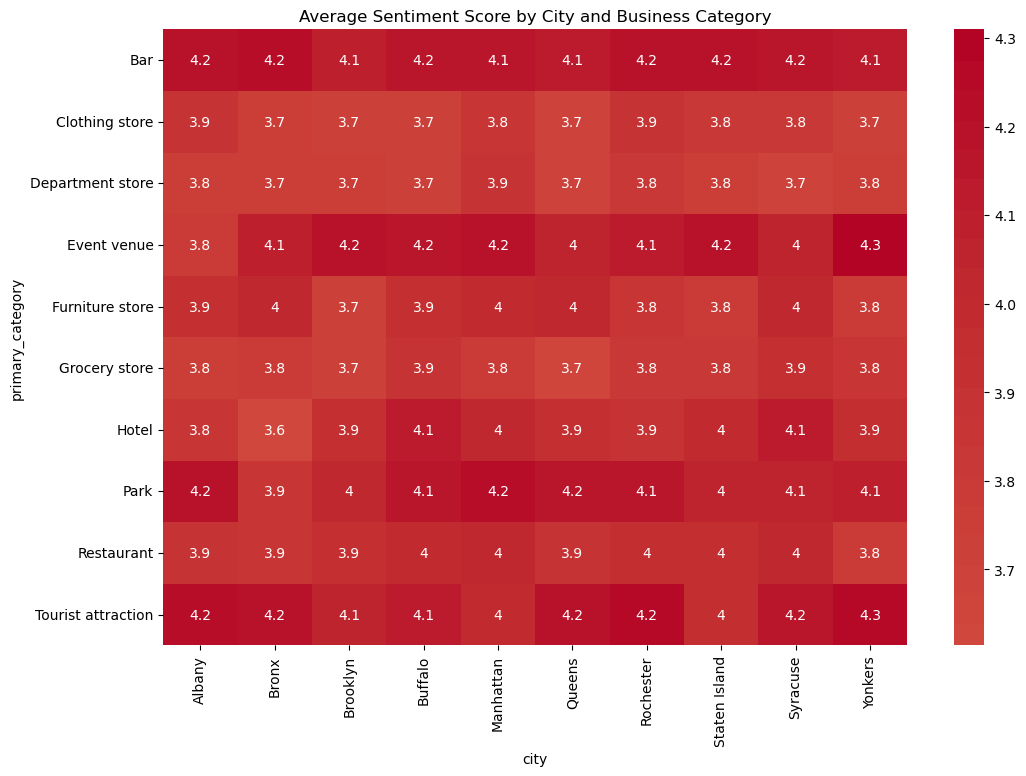

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = agg_sentiment.pivot(index='primary_category', columns='city', values='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0)
plt.title('Average Sentiment Score by City and Business Category')
plt.show()

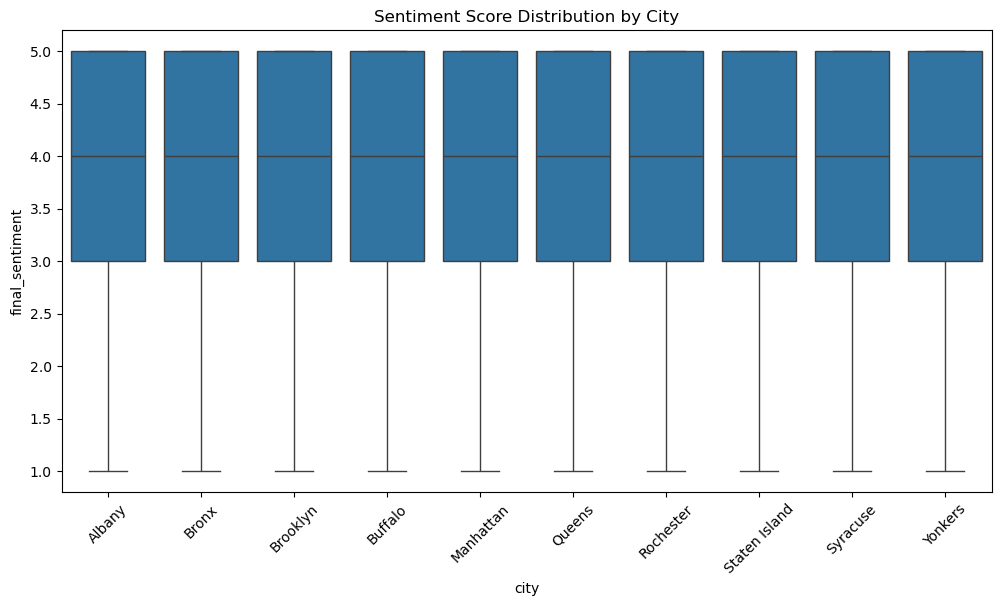

In [170]:
# Distribution of sentiment scores by city
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sentiment, x='city', y='final_sentiment')
plt.xticks(rotation=45)
plt.title('Sentiment Score Distribution by City')
plt.show()

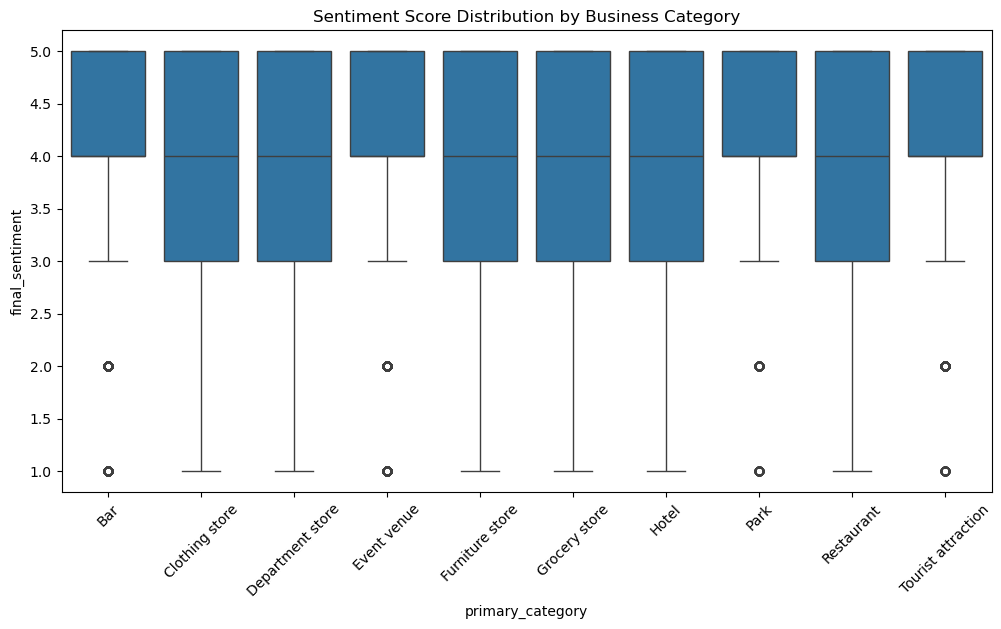

In [206]:
# Distribution of sentiment scores by city
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sentiment, x='primary_category', y='final_sentiment')
plt.xticks(rotation=45)
plt.title('Sentiment Score Distribution by Business Category')
plt.show()